In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from utils import set_plots_size_params, plot_overview 

In [2]:
freqs = pd.read_csv('loop_freqs.csv')

In [3]:
freqs.shape

(193100, 8)

In [4]:
freqs.groupby('File').Read_count.mean()

File
p10-km1.freqs     2039.805321
p10-km2.freqs     1598.280887
p10-km3.freqs     3828.880952
p3-km1           10979.864724
p3-km1.freqs      1821.680434
p3-km2.freqs      3397.971728
p3-km3.freqs      3400.860711
p7-km1.freqs      5442.029774
p7-km2.freqs      3295.625659
p7-km3.freqs      1907.024668
Name: Read_count, dtype: float64

In [5]:
freqs = freqs[freqs.File!='p3-km1'].copy()  # drop the weird one..

In [6]:
freqs['File'].value_counts()

p7-km1.freqs     19480
p3-km3.freqs     19420
p3-km1.freqs     19370
p10-km3.freqs    19320
p3-km2.freqs     19100
p7-km2.freqs     18980
p10-km1.freqs    18980
p7-km3.freqs     18850
p10-km2.freqs    18495
Name: File, dtype: int64

In [7]:
freqs['km'] = freqs.File.map(lambda string: string.split(".")[0].split("-")[1].replace("km","")).astype(int)

In [8]:
freqs['passage'] = freqs.File.map(lambda string: string.split(".")[0].split("-")[0].replace("p","")).astype(int)

In [9]:
freqs.sort_values(by=['km', 'passage', 'Pos'], inplace=True)

In [10]:
def get_loop_freqs():
    freqs = pd.read_csv('loop_freqs.csv')
    freqs = freqs[freqs.File!='p3-km1'].copy()  # drop the weird one..
    freqs['km'] = freqs.File.map(lambda string: string.split(".")[0].split("-")[1].replace("km","")).astype(int)
    freqs['passage'] = freqs.File.map(lambda string: string.split(".")[0].split("-")[0].replace("p","")).astype(int)
    freqs.sort_values(by=['km', 'passage', 'Pos'], inplace=True)
    return freqs

lfreqs = get_loop_freqs()
lfreqs.equals(freqs)

True

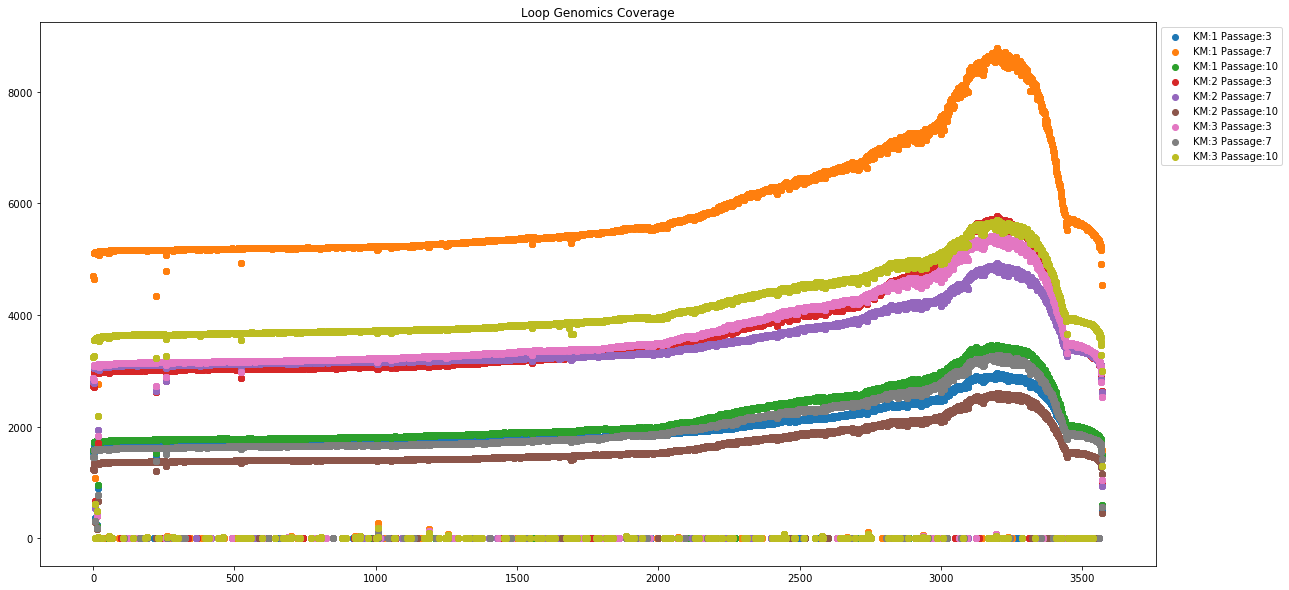

In [11]:
plt.figure(figsize=(20, 10))
for km in freqs.km.unique():
    for pas in freqs.passage.unique():
        df = freqs[freqs.km==km]
        df = df[df.passage==pas]
        plt.scatter(df.Pos, df.Read_count, label=f"KM:{km} Passage:{pas}")
plt.legend(bbox_to_anchor=(1, 1))
plt.title("Loop Genomics Coverage")
plt.savefig('loop_coverage_end.png')

In [14]:
freqs

,Pos,Base,Freq,Ref,Read_count,Rank,Prob,File,km,passage
96750,1.0,G,1.0,G,1539,0,1.0,p3-km1.freqs,1,3
96751,1.0,A,0.0,G,1539,1,-0.0,p3-km1.freqs,1,3
96752,1.0,C,0.0,G,1539,2,-0.0,p3-km1.freqs,1,3
96753,1.0,T,0.0,G,1539,3,-0.0,p3-km1.freqs,1,3
96754,1.0,-,0.0,G,1539,4,-0.0,p3-km1.freqs,1,3
...,...,...,...,...,...,...,...,...,...,...
56790,3569.0,A,1.0,A,1286,0,1.0,p10-km3.freqs,3,10
56791,3569.0,C,0.0,A,1286,1,-0.0,p10-km3.freqs,3,10
56792,3569.0,G,0.0,A,1286,2,-0.0,p10-km3.freqs,3,10
56793,3569.0,T,0.0,A,1286,3,-0.0,p10-km3.freqs,3,10


In [ ]:
set_plots_size_params(20)
fig, axes = plot_overview(freqs)
#fig.savefig('loop_overview.png')